In [3]:
import pandas as pd

import statsmodels.stats.multicomp as mc
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from scipy.stats import t, chi2

In [4]:
# Creating the DataFrame
data = {
    "English_Plant": [98, 95, 96, 91, 99],
    "Mexico_Plant": [93, 95, 91, 91, 92],
    "Vietnam_Plant": [79, 84, 67, 83, 77],
    "China_Plant": [89, 92, 85, 87, 84]
}

df = pd.DataFrame(data)

# Display the DataFrame
df

,English_Plant,Mexico_Plant,Vietnam_Plant,China_Plant
0,98,93,79,89
1,95,95,84,92
2,96,91,67,85
3,91,91,83,87
4,99,92,77,84


In [5]:
df_melt = df.melt(var_name='plant', value_name='score')

In [6]:
# Perform Tukey's HSD Test as a substitute for Duncan's Test
comp = mc.MultiComparison(df_melt['score'], df_melt['plant'])
tukey_result = comp.tukeyhsd()

# Print the results of Tukey's test
print(tukey_result.summary())

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1        group2    meandiff p-adj   lower    upper   reject
--------------------------------------------------------------------
  China_Plant English_Plant      8.4 0.0257   0.8956  15.9044   True
  China_Plant  Mexico_Plant      5.0 0.2643  -2.5044  12.5044  False
  China_Plant Vietnam_Plant     -9.4 0.0119 -16.9044  -1.8956   True
English_Plant  Mexico_Plant     -3.4 0.5782 -10.9044   4.1044  False
English_Plant Vietnam_Plant    -17.8    0.0 -25.3044 -10.2956   True
 Mexico_Plant Vietnam_Plant    -14.4 0.0003 -21.9044  -6.8956   True
--------------------------------------------------------------------


In [7]:
# Calculate group means
group_means = df.mean()

# Calculate deviations for all scores
deviations = df.apply(lambda col: col - group_means[col.name], axis=0)

# Calculate standard deviation for each group
group_std = df.std()

# Normalize deviations by standard deviation (z-scores)
z_scores = deviations.apply(lambda col: col / group_std[col.name], axis=0)

# Display deviations and z-scores
print("Deviations:")
print(deviations)
print("\nZ-scores (normalized deviations):")
print(z_scores)

Deviations:
   English_Plant  Mexico_Plant  Vietnam_Plant  China_Plant
0            2.2           0.6            1.0          1.6
1           -0.8           2.6            6.0          4.6
2            0.2          -1.4          -11.0         -2.4
3           -4.8          -1.4            5.0         -0.4
4            3.2          -0.4           -1.0         -3.4

Z-scores (normalized deviations):
   English_Plant  Mexico_Plant  Vietnam_Plant  China_Plant
0       0.706377      0.358569       0.147442     0.498542
1      -0.256865      1.553797       0.884652     1.433307
2       0.064216     -0.836660      -1.621862    -0.747812
3      -1.541187     -0.836660       0.737210    -0.124635
4       1.027458     -0.239046      -0.147442    -1.059401


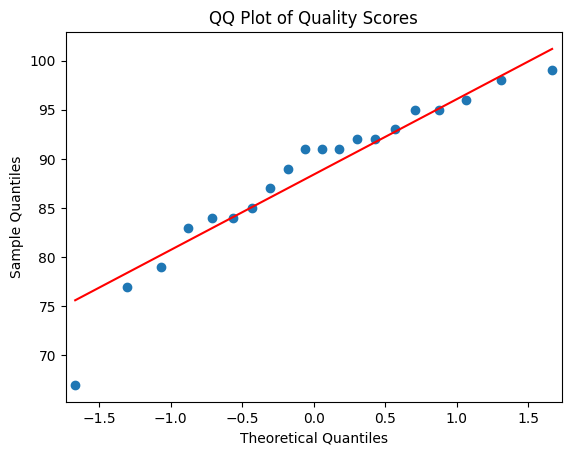

In [8]:
all_scores = df.values.flatten()

# Generate the QQ plot
sm.qqplot(all_scores, line='s')

# Add title and display the plot
plt.title('QQ Plot of Quality Scores')
plt.show()

In [9]:
# Overall mean (ȳ)
overall_mean = df.values.flatten().mean()

# Mean for each plant (ȳ_i)
means_per_plant = df.mean()

# Total Mean Square Error (MSE)
n, a = df.shape  # n: number of observations per plant, a: number of plants
N = n * a  # Total number of observations
residuals = df.subtract(means_per_plant, axis=1)
SSE = (residuals**2).sum().sum()
MSE = SSE / (N - a)

# Confidence Intervals for Overall Mean (μ)
alpha = 0.05  # 95% confidence level
t_critical = t.ppf(1 - alpha / 2, df=N - a)
ci_mu_lower = overall_mean - t_critical * np.sqrt(MSE / N)
ci_mu_upper = overall_mean + t_critical * np.sqrt(MSE / N)

# Confidence Intervals for Treatment Effects (τ_i)
ci_tau = {}
for plant, mean in means_per_plant.items():
    ci_tau_lower = mean - overall_mean - t_critical * np.sqrt(MSE * (1/n + 1/N))
    ci_tau_upper = mean - overall_mean + t_critical * np.sqrt(MSE * (1/n + 1/N))
    ci_tau[plant] = (ci_tau_lower, ci_tau_upper)

# Confidence Intervals for Variance (σ^2)
chi2_lower = chi2.ppf(alpha / 2, df=(N - a))
chi2_upper = chi2.ppf(1 - alpha / 2, df=(N - a))
ci_variance_lower = (N - a) * MSE / chi2_upper
ci_variance_upper = (N - a) * MSE / chi2_lower

# Displaying Results
results = {
    "Overall Mean (ȳ)": overall_mean,
    "Means per Plant (ȳ_i)": means_per_plant.to_dict(),
    "MSE": MSE,
    "Confidence Interval for μ": (ci_mu_lower, ci_mu_upper),
    "Confidence Intervals for τ_i": ci_tau,
    "Confidence Interval for σ^2": (ci_variance_lower, ci_variance_upper),
}

# Display results
for key, value in results.items():
    print(f"{key}: {value}")

Overall Mean (ȳ): 88.4
Means per Plant (ȳ_i): {'English_Plant': 95.8, 'Mexico_Plant': 92.4, 'Vietnam_Plant': 78.0, 'China_Plant': 87.4}
MSE: 17.2
Confidence Interval for μ: (86.43408070084448, 90.36591929915554)
Confidence Intervals for τ_i: {'English_Plant': (3.0040708088094767, 11.795929191190506), 'Mexico_Plant': (-0.39592919119051473, 8.395929191190515), 'Vietnam_Plant': (-14.79592919119052, -6.004070808809491), 'China_Plant': (-5.395929191190515, 3.3959291911905147)}
Confidence Interval for σ^2: (9.540532290242052, 39.8398048771261)


In [10]:
# Mean Square for Treatments (MS_tr)
treatment_mean_diffs = means_per_plant - overall_mean
SSTr = n * (treatment_mean_diffs**2).sum()
MS_tr = SSTr / (a - 1)

# Ratio of variances (σ_τ^2 / σ^2)
variance_ratio = (MS_tr / MSE) - 1
std_ratio = np.sqrt(variance_ratio / n)  # √(σ_τ^2 / σ^2)

# Displaying the results
ratio_results = {
    "Mean Square for Treatments (MS_tr)": MS_tr,
    "Variance Ratio (σ_τ^2 / σ^2)": variance_ratio,
    "Standard Deviation Ratio (σ_τ / σ)": std_ratio,
}

ratio_results


{'Mean Square for Treatments (MS_tr)': 299.86666666666673,
 'Variance Ratio (σ_τ^2 / σ^2)': 16.434108527131787,
 'Standard Deviation Ratio (σ_τ / σ)': 1.8129593777650832}